In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image


In [14]:

# Set random seeds for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformation for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.RandomRotation(degrees=15),  # Randomly rotate the image by up to 15 degrees
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Randomly crop and resize the image
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Apply Gaussian blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Load dataset
dataset = datasets.ImageFolder("./Dataset_Randstain", transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
# Save the model
model = torch.load('./models/DenseNet161_randstain/densenet161.pth')


In [16]:

# Function to extract features using the DenseNet model
def extract_features(model, dataloader):
    model.eval()  # Set model to evaluation mode
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model.features(inputs)  # Extract features
            
            # Flatten the output tensor to (batch_size, num_features)
            outputs = torch.flatten(outputs, 1)
            
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    
    return features, labels

In [17]:
# Extract features from the trained model
train_features, train_labels = extract_features(model, train_loader)
val_features, val_labels = extract_features(model, val_loader)

In [18]:
# Train a Logistic Regression model on the extracted features
clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labels)

# Predict on the validation features
val_preds = clf.predict(val_features)



Classification Report:
              precision    recall  f1-score   support

     Healthy       0.76      0.83      0.79        41
   Cancerous       0.67      0.56      0.61        25

    accuracy                           0.73        66
   macro avg       0.71      0.69      0.70        66
weighted avg       0.72      0.73      0.72        66



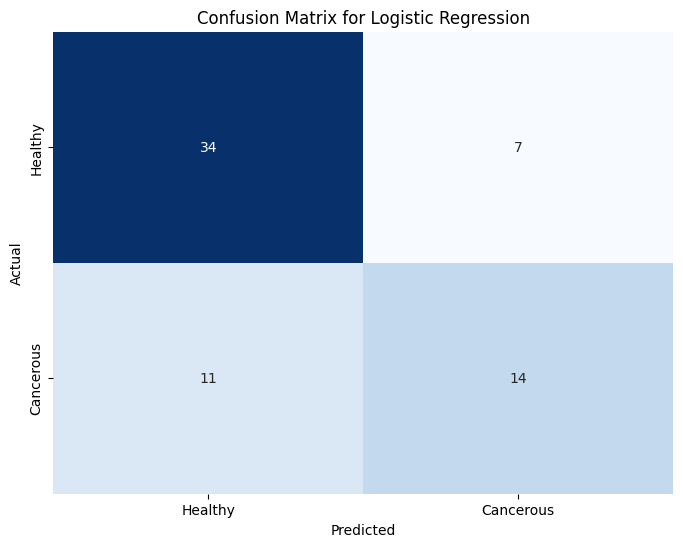

In [22]:

# Evaluate the Logistic Regression model
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=['Healthy', 'Cancerous']))

conf_matrix = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Healthy', 'Cancerous'], yticklabels=['Healthy', 'Cancerous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


In [23]:
# Function to predict a single image using the DenseNet model and Logistic Regression
class_labels = ["Healthy", "Cancerous"]

def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')  
    image_tensor = transform(image)  
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        features = model.features(image_tensor.to(device))
        features = torch.flatten(features, 1).cpu().numpy()
        predicted = clf.predict(features)
        predicted_class = class_labels[int(predicted[0])]

    return predicted_class, image


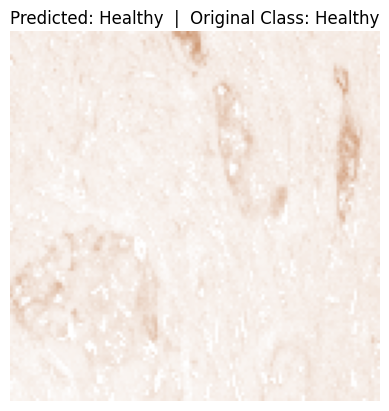

In [24]:

# Function to plot the prediction
def plot_prediction(image_path):
    predicted_class, image = predict_image(image_path)
    if "cancer" in image_path.lower():
        original_class = "Cancerous"
    else:
        original_class = "Healthy"

    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}  |  Original Class: {original_class}')
    plt.axis('off') 
    plt.show()

# Predict and plot a sample image
image_path = './Dataset/HEALTHY/11354 (9).png'
plot_prediction(image_path)


Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Healthy       0.76      0.83      0.79        41
   Cancerous       0.67      0.56      0.61        25

    accuracy                           0.73        66
   macro avg       0.71      0.69      0.70        66
weighted avg       0.72      0.73      0.72        66



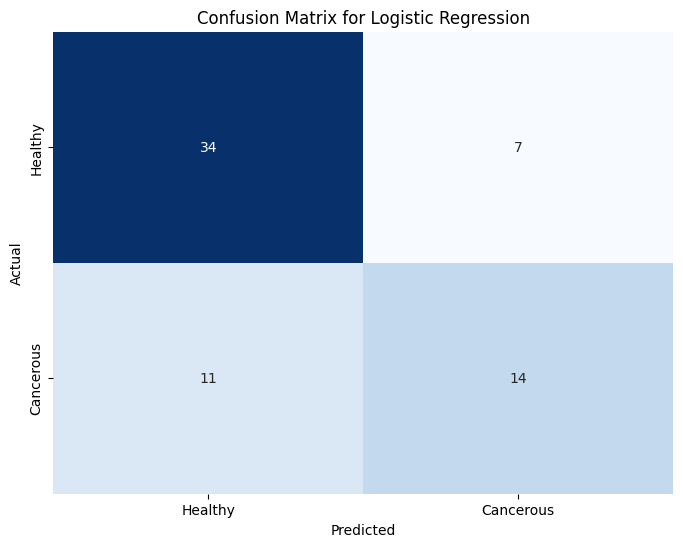


Random Forest Classification Report:
              precision    recall  f1-score   support

     Healthy       0.83      0.83      0.83        41
   Cancerous       0.72      0.72      0.72        25

    accuracy                           0.79        66
   macro avg       0.77      0.77      0.77        66
weighted avg       0.79      0.79      0.79        66



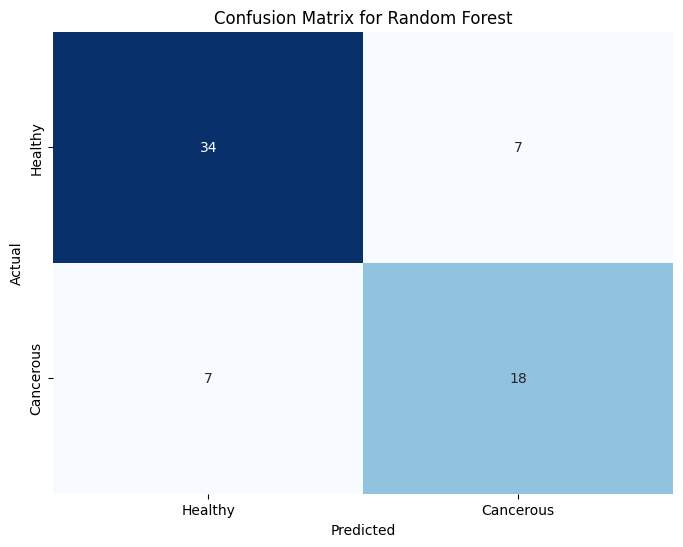


SVM Classification Report:
              precision    recall  f1-score   support

     Healthy       0.76      0.83      0.79        41
   Cancerous       0.67      0.56      0.61        25

    accuracy                           0.73        66
   macro avg       0.71      0.69      0.70        66
weighted avg       0.72      0.73      0.72        66



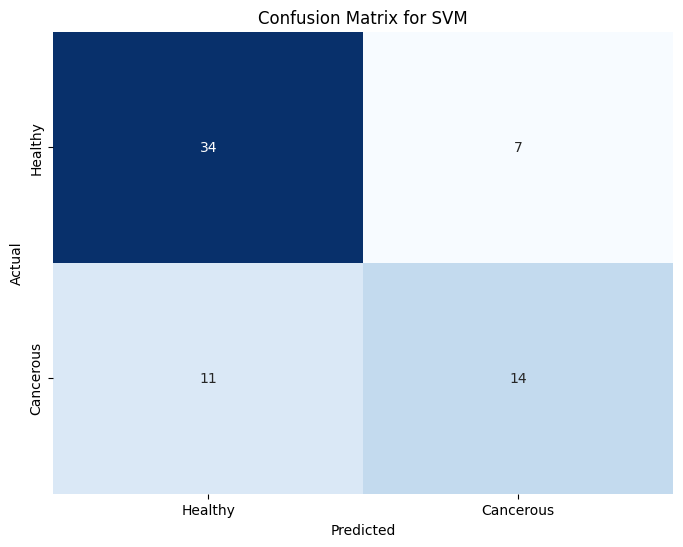


k-NN Classification Report:
              precision    recall  f1-score   support

     Healthy       0.81      0.95      0.88        41
   Cancerous       0.89      0.64      0.74        25

    accuracy                           0.83        66
   macro avg       0.85      0.80      0.81        66
weighted avg       0.84      0.83      0.83        66



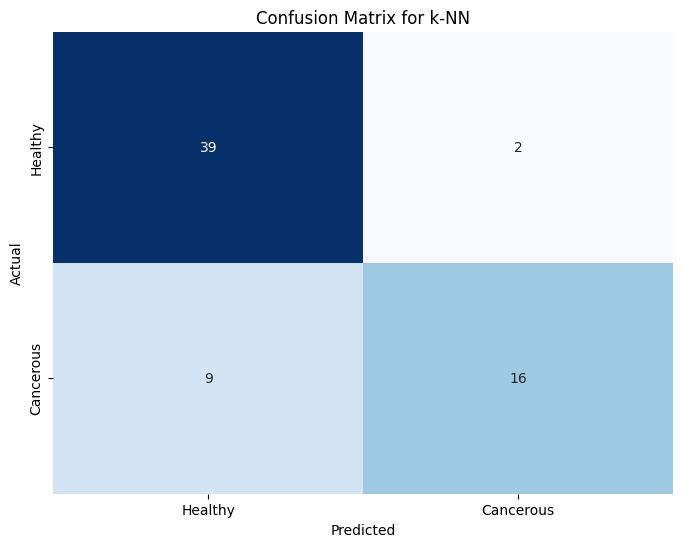


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

     Healthy       0.80      0.90      0.85        41
   Cancerous       0.80      0.64      0.71        25

    accuracy                           0.80        66
   macro avg       0.80      0.77      0.78        66
weighted avg       0.80      0.80      0.80        66



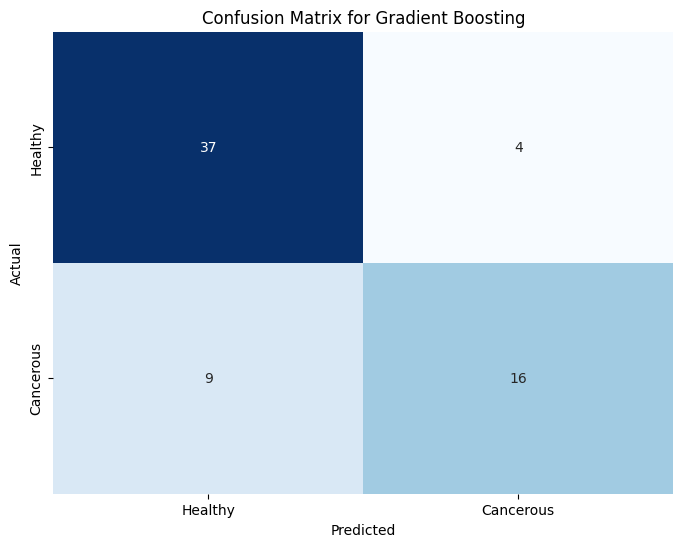

In [27]:
# Define the models to train
models_to_train = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='linear'),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

# Train and evaluate each model
for name, clf in models_to_train.items():
    # Train the model
    clf.fit(train_features, train_labels)
    
    # Predict on the validation features
    val_preds = clf.predict(val_features)
    
    # Evaluate the model
    print(f"\n{name} Classification Report:")
    print(classification_report(val_labels, val_preds, target_names=['Healthy', 'Cancerous']))
    
    conf_matrix = confusion_matrix(val_labels, val_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Healthy', 'Cancerous'], yticklabels=['Healthy', 'Cancerous'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()